In [38]:
import pandas as pd
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [39]:
min_f=1
max_f=12

algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
algo_dict["rs_pb"]=["random_search","pb_mutation_dynamic_geometric-default-at-target"]
algo_dict["hb_pb"]=["hyperband","pb_mutation_dynamic_geometric-default-at-target"]
prior_dict={"good+bad":["at25","bad"]}#,"all":list(df["prior"].unique())}
benchmark_dict={"big_selection":['lcbench-167190', 'jahs_colorectal_histology','translatewmt_xformer_64', 'jahs_cifar10', 'lm1b_transformer_2048','lcbench-126026', 'cifar100_wideresnet_2048', 'imagenet_resnet_512', 'lcbench-168330', 'lcbench-189906', 'lcbench-168910','jahs_fashion_mnist']}
benchmark_dict["jahs_cifar10"]=['jahs_cifar10']
benchmark_dict["lcbench-167190"]=['lcbench-167190']
benchmark_dict["imagenet_resnet_512"]=["imagenet_resnet_512"]
benchmark_dict['jahs_colorectal_histology']=['jahs_colorectal_histology']
benchmark_dict["translatewmt_xformer_64"]=["translatewmt_xformer_64"]

for priortype in df["prior"].unique():
    prior_dict[priortype]=[priortype]
df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for benchmark_key,benchmark_value in benchmark_dict.items():
        df_dict[prior_key][benchmark_key]={}
        for benchmark in benchmark_value:
            df_dict[prior_key][benchmark_key][benchmark]={}
            for algo_key,algo_value in algo_dict.items():
                df_dict[prior_key][benchmark_key][benchmark][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)&(df["used_fidelity"]>=min_f)&(df["used_fidelity"]<=max_f)].reset_index(drop=True)

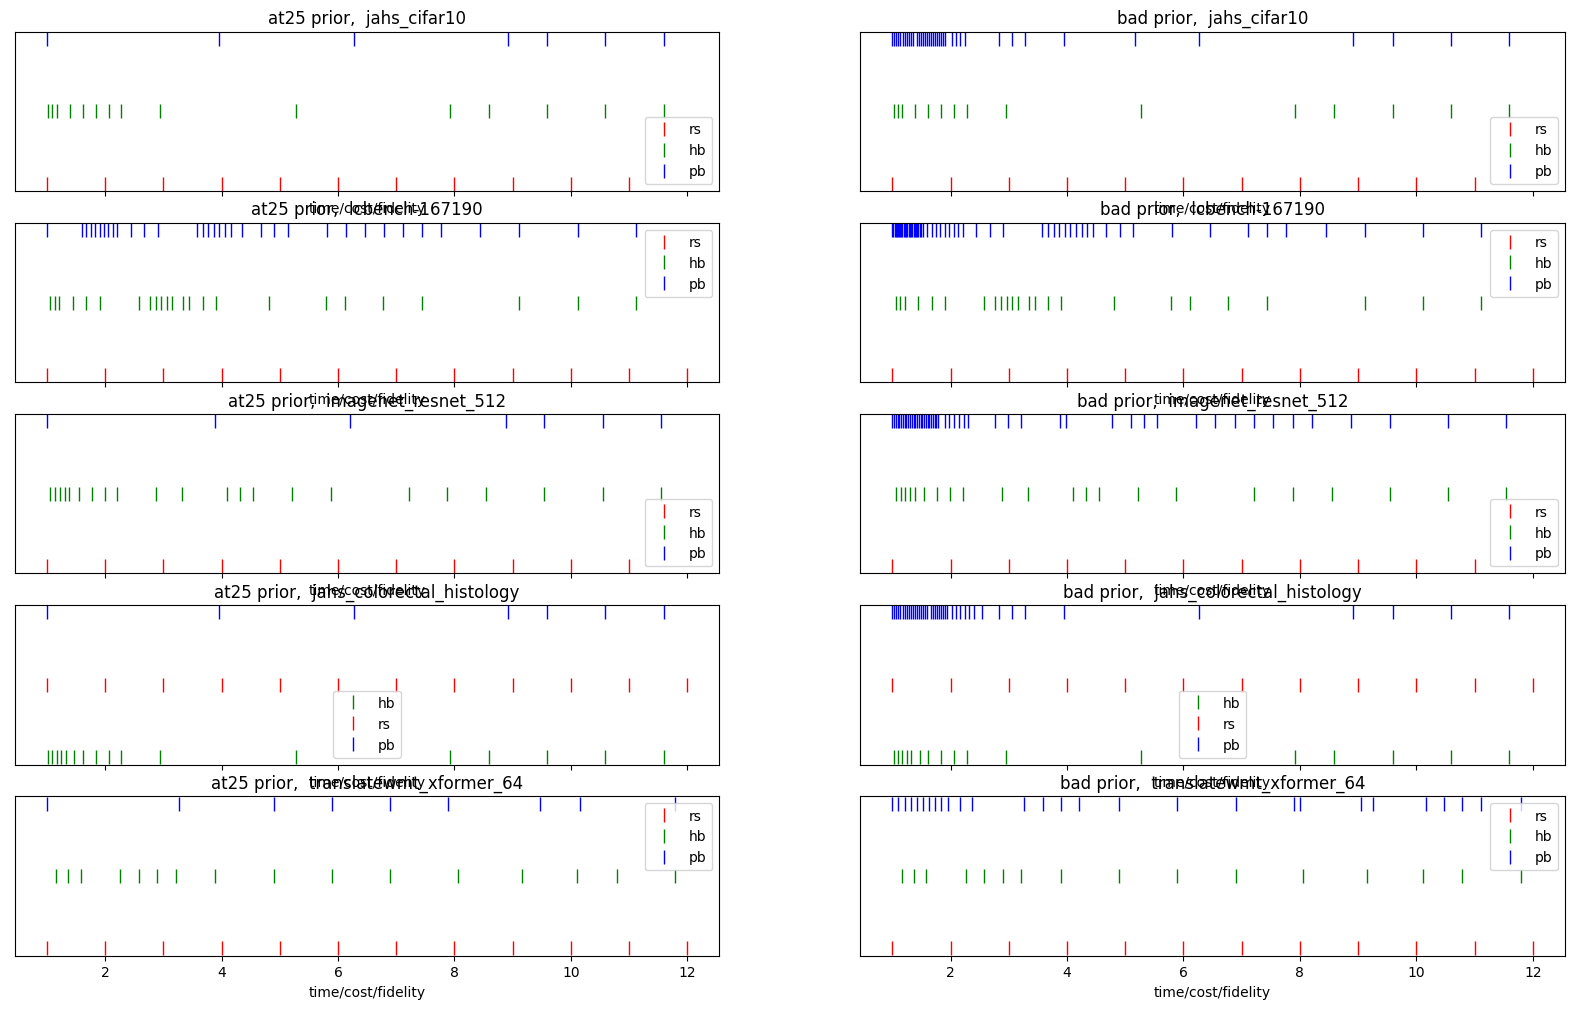

In [40]:
import matplotlib.pyplot as plt

priors=["at25","bad"]
algos="rs_hb_pb"
selections=["jahs_cifar10","lcbench-167190","imagenet_resnet_512","jahs_colorectal_histology","translatewmt_xformer_64"]
color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue"}
label_dict={"random_search":"rs","hyperband":"hb","pb_mutation_dynamic_geometric-default-at-target":"pb","priorband":"pb"}


_, axis = plt.subplots(len(selections),len(priors),figsize=(20, 12),sharex=True)
for p_n,priortype in enumerate(priors):
    for bs_n,benchmark_selection in enumerate(selections):
        for b_n,benchmark in enumerate(df_dict[priortype][benchmark_selection].keys()):
            dataset=df_dict[priortype][benchmark_selection][benchmark][algos]
            fidelities_steps=dataset["used_fidelity"].unique()
            for s_n,system in enumerate(df_dict[prior_key][benchmark_selection][benchmark][algos]["algorithm"].unique()):
                x_data=[]
                y_data=[]
                for f in fidelities_steps:
                    if len(dataset.loc[(dataset["algorithm"]==system)&(dataset["used_fidelity"]==f)])>0:
                        y_data.append(s_n)
                        x_data.append(f)
                axis[bs_n+b_n*bs_n,p_n].errorbar(
                    x_data,
                    y_data,
                    fmt="|",
                    markersize=10,
                    capsize=1,
                    label=label_dict[system],
                    color=color_dict[system]
                )
                
            axis[bs_n+b_n*bs_n,p_n].set_xlabel("time/cost/fidelity")
            axis[bs_n+b_n*bs_n,p_n].set_title(f"{priortype} prior,  {benchmark}")
            axis[bs_n+b_n*bs_n,p_n].get_yaxis().set_visible(False)
            axis[bs_n+b_n*bs_n,p_n].legend()


plt.show()

In [41]:
def autorank_formatter(df:pd.DataFrame,system_id:str,metric:str,used_fidelity_min=None, used_fidelity_max:float=None,):
    if not used_fidelity_max:
        used_fidelity_max=max(df["used_fidelity"])
    if not used_fidelity_min:
        used_fidelity_min=min(df["used_fidelity"])
    df_collector=[]
    for algo in df[system_id].unique():
        algo_df=pd.DataFrame(df.loc[(df[system_id]==algo)&(df["used_fidelity"]<=used_fidelity_max)&(df["used_fidelity"]>=used_fidelity_min)][metric])
        algo_df=algo_df.rename(columns={metric:algo})
        df_collector.append(algo_df[algo].to_list())
    df_collector=list(zip(*df_collector))
    return pd.DataFrame(df_collector,columns=df[system_id].unique())

In [47]:
from autorank import autorank, create_report, plot_stats
import warnings
warnings.filterwarnings("ignore","p-value may not be accurate for N > 5000.")
from matplotlib import pyplot as plt
experiment={}
experiment["plots"]=False
experiment["priors"]=["good+bad","at25","bad"]
experiment["benchmarks"]=["jahs_cifar10","lcbench-167190","imagenet_resnet_512","jahs_colorectal_histology","translatewmt_xformer_64"]
experiment["algos"]="rs_hb_pb"

df_dict_autorank={}
for priortype in experiment["priors"]:
    df_dict_autorank[priortype]={}
    for benchmark_selection in df_dict[priortype].keys():
        df_dict_autorank[priortype][benchmark_selection]={}
        for benchmark in df_dict[priortype][benchmark_selection].keys():
            df_dict_autorank[priortype][benchmark_selection][benchmark]=autorank_formatter(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]],"algorithm","value")
            

# PriorBand Analysis with Autorank for all cost/time/fidelities combined/ignored
result_dict={}
result_dict_average={}
for priortype in experiment["priors"]:
    result_dict[priortype]={}
    result_dict_average[priortype]={}
    for benchmark_selection in experiment["benchmarks"]:
        result_dict[priortype][benchmark_selection]={}
        result_dict_average[priortype][benchmark_selection]={}
        for benchmark in df_dict_autorank[priortype][benchmark_selection].keys():
            result_dict[priortype][benchmark_selection][benchmark]=autorank(df_dict_autorank[priortype][benchmark_selection][benchmark],
                    alpha=0.05,
                    verbose=False)
            if experiment["plots"]:
                plot_stats(result_dict[priortype][benchmark_selection][benchmark])
                # print(f"Random Search vs. HyperBand vs. PriorBand on Prior: {priortype} and Benchmark: {benchmark}")
                # plt.show()
                # print(result_dict[priortype][benchmark_selection][benchmark])
            for algo in result_dict[priortype][benchmark_selection][benchmark][0].index:
                result_dict_average[priortype][benchmark_selection][algo]=0
        for benchmark in result_dict[priortype][benchmark_selection].keys():
            for algo in result_dict[priortype][benchmark_selection][benchmark][0].index:
                result_dict_average[priortype][benchmark_selection][algo]+=result_dict[priortype][benchmark_selection][benchmark][0].loc[algo]["median"]
            for algo in result_dict[priortype][benchmark_selection][benchmark][0].index:
                result_dict_average[priortype][benchmark_selection][algo]/=len(result_dict[priortype][benchmark_selection].keys())
        #print(df_dict_autorank[priortype][benchmark_selection]["jahs_cifar10"])
        print(f"Random Search vs. HyperBand vs. PriorBand on Prior: {priortype} and Benchmark-Selection: {benchmark_selection}")
        print(result_dict_average[priortype][benchmark_selection],"\n")

Random Search vs. HyperBand vs. PriorBand on Prior: good+bad and Benchmark-Selection: jahs_cifar10
{'random_search': 10.896751403808594, 'hyperband': 13.996681213378906, 'pb_mutation_dynamic_geometric-default-at-target': 33.04407501220703} 

Random Search vs. HyperBand vs. PriorBand on Prior: good+bad and Benchmark-Selection: lcbench-167190
{'hyperband': 0.19735664129257202, 'random_search': 0.2165582776069641, 'pb_mutation_dynamic_geometric-default-at-target': 0.21775281429290771} 

Random Search vs. HyperBand vs. PriorBand on Prior: good+bad and Benchmark-Selection: imagenet_resnet_512
{'random_search': 0.30164673924446106, 'hyperband': 0.3191482424736023, 'pb_mutation_dynamic_geometric-default-at-target': 0.4919278621673584} 

Random Search vs. HyperBand vs. PriorBand on Prior: good+bad and Benchmark-Selection: jahs_colorectal_histology
{'random_search': 6.39654541015625, 'hyperband': 16.39638900756836, 'pb_mutation_dynamic_geometric-default-at-target': 33.574363708496094} 

Random 

c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\autorank\_util.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\autorank\_util.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)


In [48]:
import numpy as np
system_id="algorithm"
steps=12
quantiles=False

df_dict_autorank_fidelities={}
for priortype in experiment["priors"]:
    df_dict_autorank_fidelities[priortype]={}
    for benchmark_selection in experiment["benchmarks"]:
        df_dict_autorank_fidelities[priortype][benchmark_selection]={}
        for benchmark in df_dict_autorank[priortype][benchmark_selection].keys():
            df_dict_autorank_fidelities[priortype][benchmark_selection][benchmark]={}
            if quantiles:
                linspace=np.quantile(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]].loc[(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]]["used_fidelity"]>=min_f)&(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]]["used_fidelity"]<=max_f)]["used_fidelity"],np.linspace(0,1,num=steps,endpoint=True))
                for n,f in enumerate(linspace[:-1]):
                    df_at_fidelity=autorank_formatter(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]],"algorithm","value",f,linspace[n+1]) 
                    passed=True
                    for system in df_at_fidelity.columns:
                        if len(df_at_fidelity[system])<5:
                            passed=False
                    if passed:
                        df_dict_autorank_fidelities[priortype][benchmark][benchmark_selection][linspace[n+1]]=df_at_fidelity
            else:
                # print(df_dict[priortype]["RS+HB+PB"]["prior"].value_counts())
                for f in np.linspace(max(min_f,min(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]]["used_fidelity"])),min(max_f,max(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]]["used_fidelity"])),num=steps,endpoint=True)[1:]:
                    print(f"{priortype}, {round(f,4)}           ",end="\r",flush=True)
                    df_dict_autorank_fidelities[priortype][benchmark_selection][benchmark][f]=autorank_formatter(df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]],"algorithm","value",used_fidelity_max=f)

In [49]:

scores={}
values={}
for n_prior,priortype in enumerate(df_dict_autorank_fidelities.keys()):
    scores[priortype]={}
    values[priortype]={}
    for benchmark_selection in experiment["benchmarks"]:
        scores[priortype][benchmark_selection]={}
        values[priortype][benchmark_selection]={}
        for benchmark in df_dict_autorank[priortype][benchmark_selection].keys():
            fidelities_steps=list(df_dict_autorank_fidelities[priortype][benchmark_selection][benchmark].keys())
            scores[priortype][benchmark_selection][benchmark]={}
            values[priortype][benchmark_selection][benchmark]={}
            for system in df_dict_autorank_fidelities[priortype][benchmark_selection][benchmark][list(df_dict_autorank_fidelities[priortype][benchmark_selection][benchmark].keys())[0]].keys():
                scores[priortype][benchmark_selection][benchmark][system]={}
                values[priortype][benchmark_selection][benchmark][system]={}
                values[priortype][benchmark_selection][benchmark][system]["mean"]=[]
                values[priortype][benchmark_selection][benchmark][system]["std"]=[]
                scores[priortype][benchmark_selection][benchmark][system]["mean"]=[]
                scores[priortype][benchmark_selection][benchmark][system]["uplim"]=[]
                scores[priortype][benchmark_selection][benchmark][system]["lolim"]=[]
            for n_f,f in enumerate(fidelities_steps):
                # print(priortype,len(df_dict_autorank_fidelities[priortype][f]))
                #print(f"Prior {n_prior+1}/{len(df_dict_autorank_fidelities.keys())}: Fidelity {n_f+1}/{len(fidelities_steps)}  ",end="\r",flush=True)
                result_frame=autorank(df_dict_autorank_fidelities[priortype][benchmark_selection][benchmark][f],
                        alpha=0.5,
                        verbose=False)[0]
                for system in result_frame.index:
                    df_at_fidelity=df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]].loc[df_dict[priortype][benchmark_selection][benchmark][experiment["algos"]]["used_fidelity"]<=f]
                    values[priortype][benchmark_selection][benchmark][system]["mean"].append(df_at_fidelity.loc[df_at_fidelity["algorithm"]==system]["value"].mean())
                    values[priortype][benchmark_selection][benchmark][system]["std"].append(df_at_fidelity.loc[df_at_fidelity["algorithm"]==system]["value"].std())
                    scores[priortype][benchmark_selection][benchmark][system]["mean"].append(result_frame.loc[system,"median"])
                    scores[priortype][benchmark_selection][benchmark][system]["uplim"].append(result_frame.loc[system,"ci_lower"])
                    scores[priortype][benchmark_selection][benchmark][system]["lolim"].append(result_frame.loc[system,"ci_upper"])
                    # print(len(scores[priortype][system]))

c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\autorank\_util.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\autorank\_util.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\li

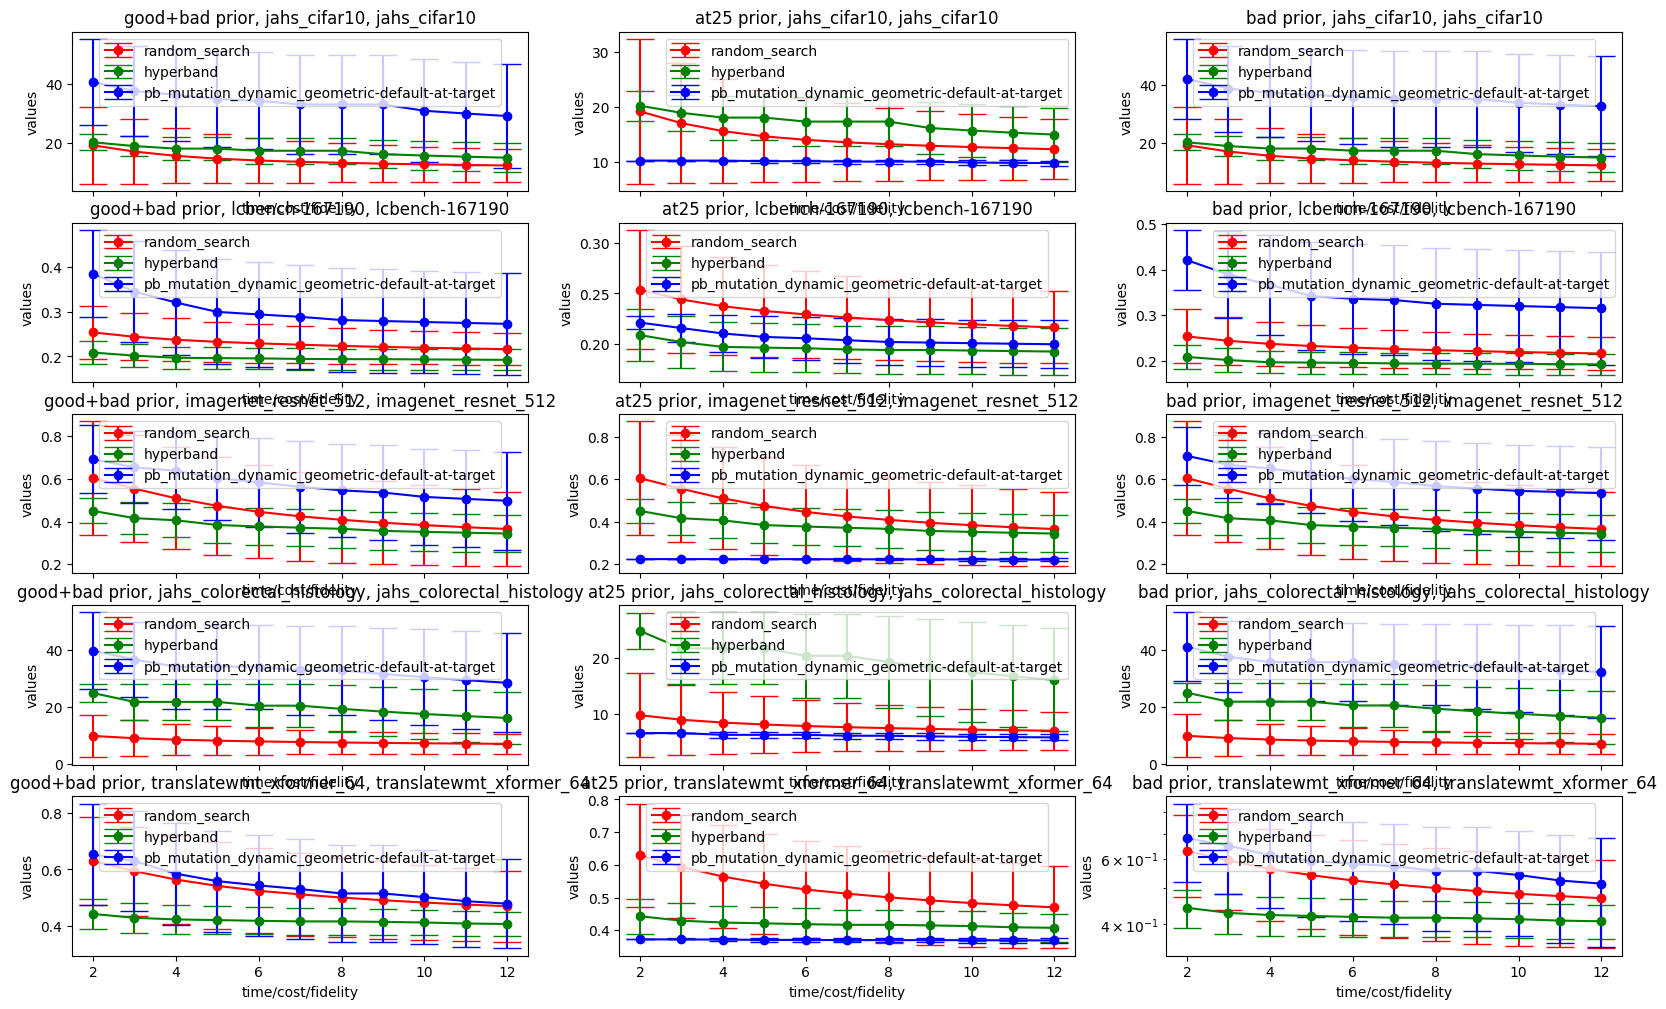

In [54]:
color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue"}

_, axis = plt.subplots(len(values["at25"].keys()),len(values.keys()),figsize=(20, 12),sharex=True)
for p_n,priortype in enumerate(values.keys()):
    for bs_n,benchmark_selection in enumerate(values[priortype].keys()):
        for b_n,benchmark in enumerate(values[priortype][benchmark_selection].keys()):
            for s_n,system in enumerate(values[priortype][benchmark_selection][benchmark]):
                axis[bs_n*b_n+bs_n,p_n].errorbar(
                    fidelities_steps,
                    values[priortype][benchmark_selection][benchmark][system]["mean"],
                    fmt="o-",
                    yerr=values[priortype][benchmark_selection][benchmark][system]["std"],
                    capsize=10,
                    label=system,
                    color=color_dict[system]
                )
            axis[bs_n*b_n+bs_n,p_n].set_xlabel("time/cost/fidelity")
            axis[bs_n*b_n+bs_n,p_n].set_ylabel("values")
            axis[bs_n*b_n+bs_n,p_n].set_title(f"{priortype} prior, {benchmark_selection}, {benchmark}")
            axis[bs_n*b_n+bs_n,p_n].legend()

from functools import partial
plt.yscale('log')
plt.show()

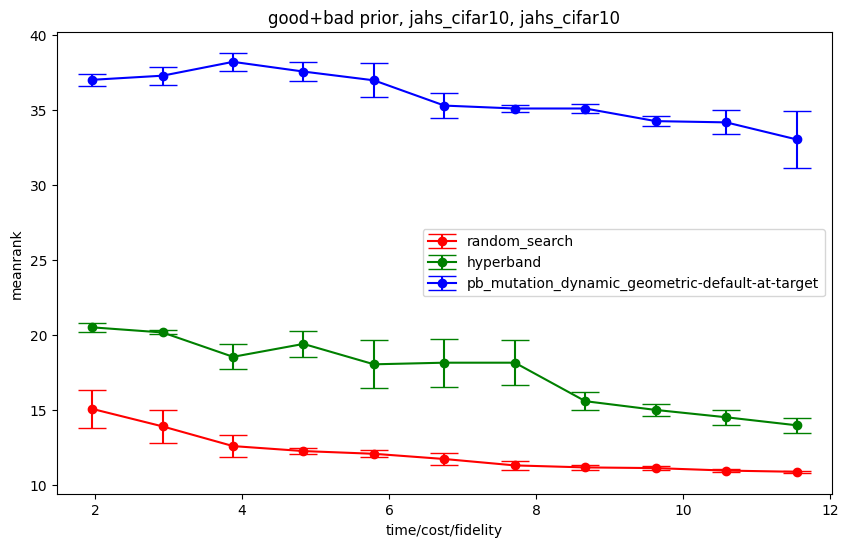

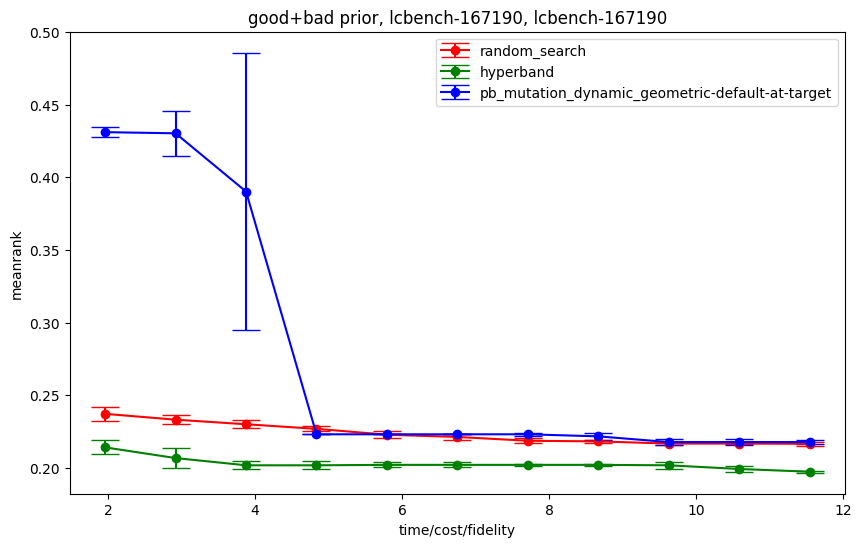

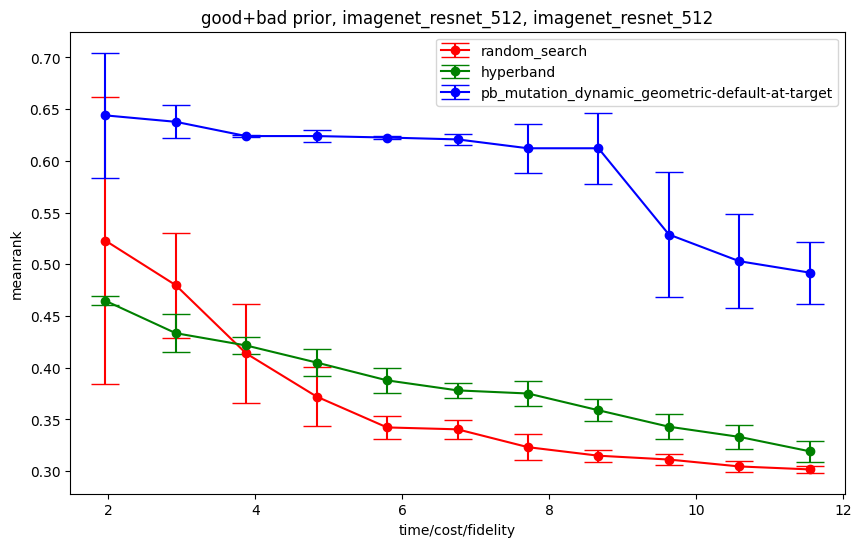

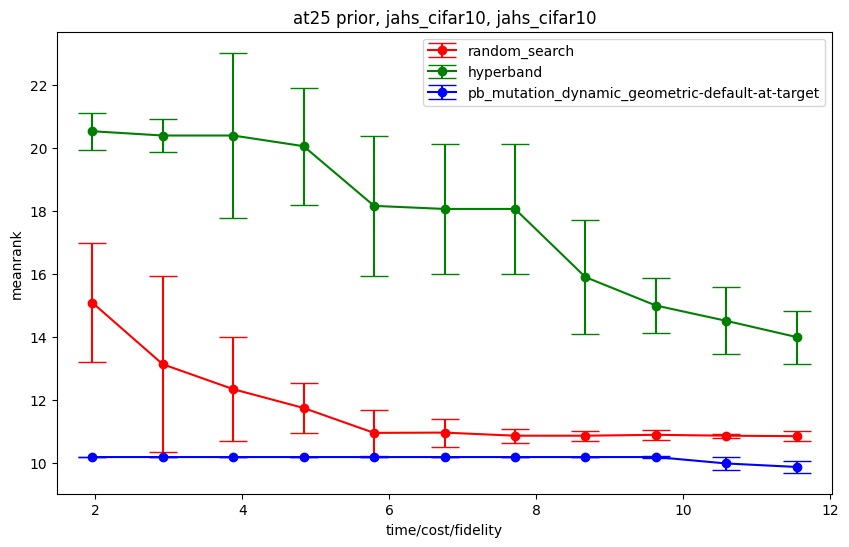

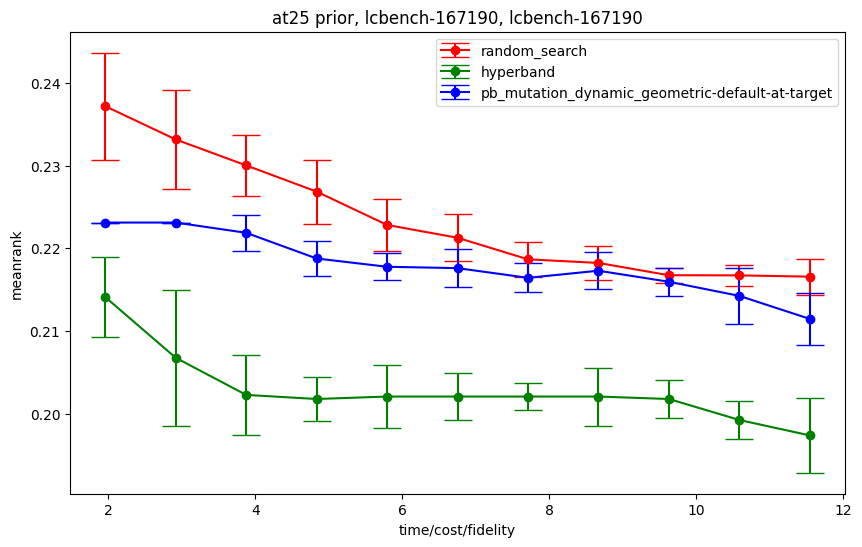

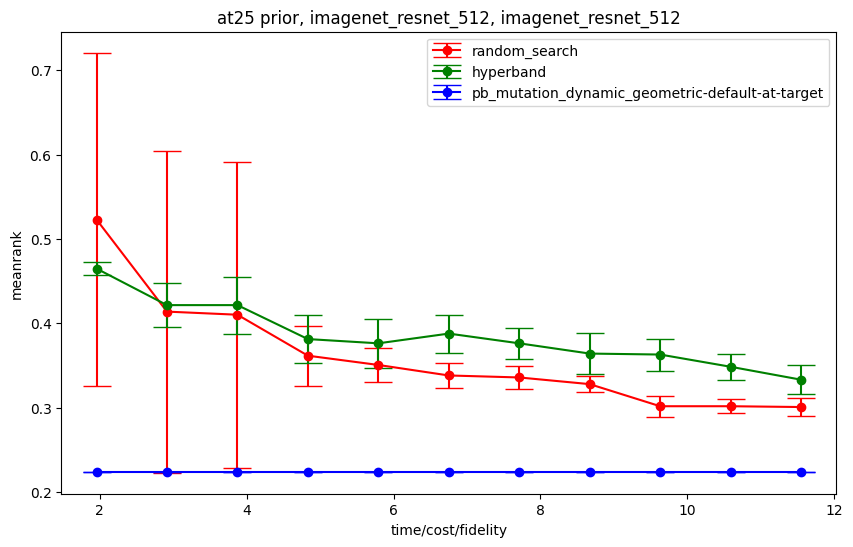

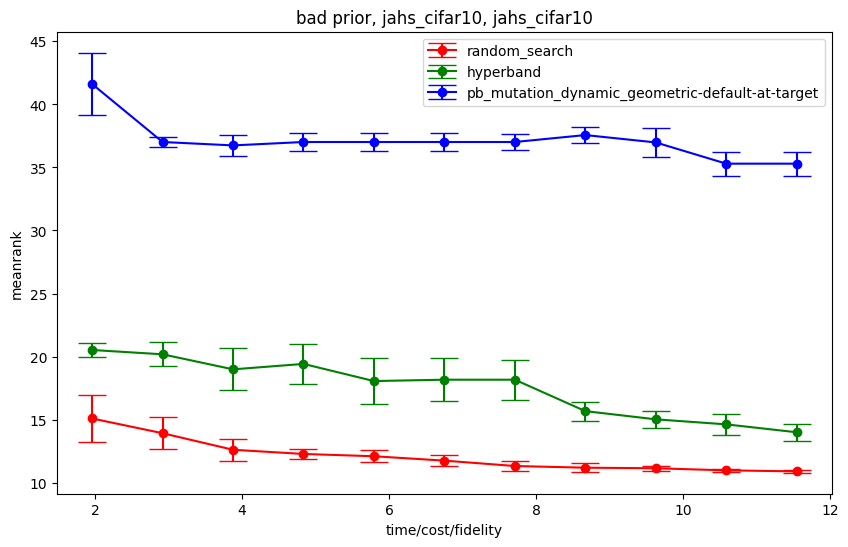

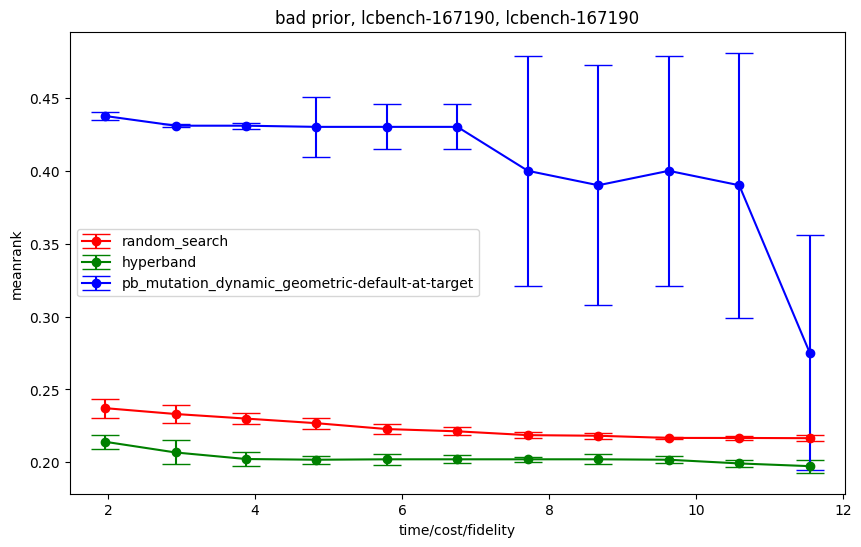

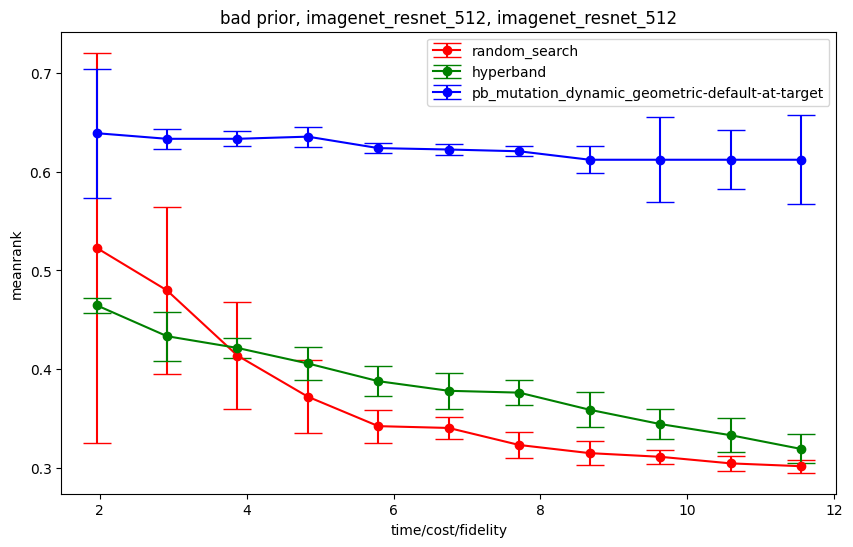

In [46]:
color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue"}

for priortype in scores.keys():
    for benchmark_selection in scores[priortype].keys():
        for benchmark in scores[priortype][benchmark_selection].keys():
            _, axis = plt.subplots(figsize=(10, 6))
            for system in scores[priortype][benchmark_selection][benchmark]:
                axis.errorbar(
                    fidelities_steps,
                    scores[priortype][benchmark_selection][benchmark][system]["mean"],
                    fmt="o-",
                    yerr=(np.array(scores[priortype][benchmark_selection][benchmark][system]["lolim"])-np.array(scores[priortype][benchmark_selection][benchmark][system]["uplim"]))/2,
                    capsize=10,
                    label=system,
                    color=color_dict[system]
                )
            axis.set_xlabel("time/cost/fidelity")
            axis.set_ylabel("meanrank")
            axis.set_title(f"{priortype} prior, {benchmark_selection}, {benchmark}")
            axis.legend()

from functools import partial
#plt.yscale('symlog')
plt.show()